In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
import xarray as xr

import decoherence as dc

plt.style.use("seaborn-ticks")

/var/folders/k3/y60qc5dn2lsff_h2hgv2zlbc0000gn/T/ipykernel_9044/1899452351.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-ticks")


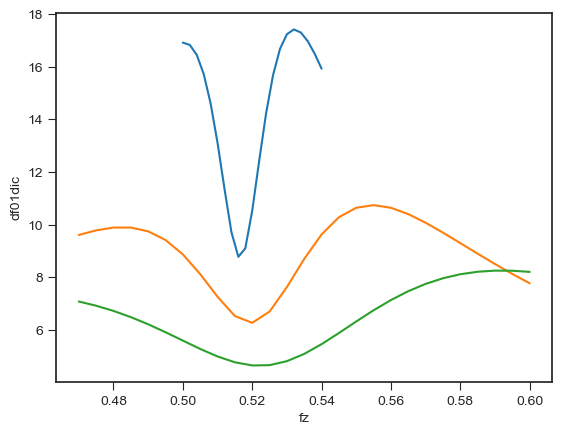

In [10]:
fxs = [0.32, 0.36, 0.40]
sensitivity_data = []
for i, fx in enumerate(fxs):
    with open(f"DeviceParameters/IcSensitivityData{fx * 100:.0f}.json", "r") as f:
        f = json.load(f)
        sensitivity_data.append(
            xr.Dataset(
                data_vars = {
                    key: ("fz", [d["Average"][key] for d in f["Data"]]) for key in ["df01dic1", "df01dic2", "df01dicl", "df01dicr"]
                },
                coords = {"fz": f["SweepSpecifiers"][0][1]}
            )
        )
    sensitivity_data[i]["df01dic"] = xr.DataArray(
        np.sqrt(np.sum([sensitivity_data[i][key] ** 2 for key in ["df01dic1", "df01dic2", "df01dicl", "df01dicr"]], axis=0)),
        coords = {"fz": f["SweepSpecifiers"][0][1]}
    )
for d in sensitivity_data:
    d["df01dic"].plot()

In [24]:
def t_phi_ic(d_omega_d_ic, A_ic, t_acq, t_au0):
    """from Feiyan 2012 PRB
    Parameters
    ----------
    d_omega_d_ic: normalized noise sensitivity
    A_ic: ic 1/f noise amplitude
    t_acq: Acquisition time
    t_0: typical dephasing tim
    """
    return d_omega_d_ic ** (-1) * A_ic**(-1/2)*(np.log(t_acq/2/t_0))**(-1/2)
    

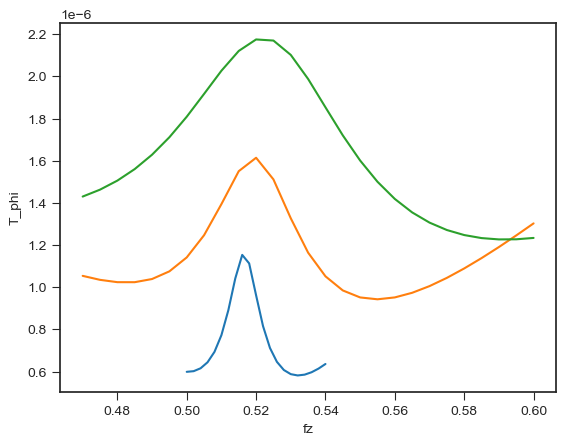

In [25]:
A_ic = (4e-6)**2
t_acq = 10
t_0 = 1e-6

for d in sensitivity_data:
    d["T_phi"] = xr.DataArray(
        [t_phi_ic(d_f01 * 2 * np.pi * 1e9, A_ic, t_acq, t_0) for d_f01 in d["df01dic"].data],
        coords = {"fz": d["fz"].data}
    )
    d["T_phi"].plot()
